In [1]:
import sys
sys.path.insert(1, './env')
sys.path.insert(1, './agents')

import gym
import pylab
import random
import strategy_imitation, sarsa, ddqn, random_agent, a2c, model_based,graph_ai
import aa_gun,jet_table_simple
import numpy as np
from collections import deque
import keras
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#массовый тест моделей

_____ 2020-07-13 21:27:35.093630
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               5100      
_________________________________________________________________
batch_normalization (BatchNo (None, 300)               1200      
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)        

A0 0 days 00:00:00.016434
A0 0 days 00:00:00.016268
A0 0 days 00:00:00.016385
A0 0 days 00:00:00.016215
A0 0 days 00:00:00.016220
A0 0 days 00:00:00.016465
A0 0 days 00:00:00.016310
A0 0 days 00:00:00.016309
A0 0 days 00:00:00.016199
A0 0 days 00:00:00.016599
A0 0 days 00:00:00.015927
A0 0 days 00:00:00.016397
A0 0 days 00:00:00.016180
A0 0 days 00:00:00.016112
A0 0 days 00:00:00.016367
A0 0 days 00:00:00.016213
A0 0 days 00:00:00.016318
A0 0 days 00:00:00.016256
A0 0 days 00:00:00.016425
A0 0 days 00:00:00.016526
A0 0 days 00:00:00.016243
A0 0 days 00:00:00.016346
A0 0 days 00:00:00.016377
A0 0 days 00:00:00.017664
A0 0 days 00:00:00.014703
A0 0 days 00:00:00.016315
A0 0 days 00:00:00.016306
A0 0 days 00:00:00.016089
A0 0 days 00:00:00.016298
A0 0 days 00:00:00.016224
A0 0 days 00:00:00.016481
A0 0 days 00:00:00.015953
A0 0 days 00:00:00.016317
A0 0 days 00:00:00.017861
A0 0 days 00:00:00.014740
A0 0 days 00:00:00.016038
A0 0 days 00:00:00.016138
A0 0 days 00:00:00.016580
A0 0 days 00

1/1 [==============================] - 0s 1ms/step - loss: 3.9854
Epoch 3/4
1/1 [==============================] - 0s 1ms/step - loss: 4.2321
Epoch 4/4
1/1 [==============================] - 0s 1ms/step - loss: 3.9699
ssar_fit
Epoch 1/4
1/1 [==============================] - 0s 748us/step - loss: 3.2428
Epoch 2/4
1/1 [==============================] - 0s 1ms/step - loss: 4.3620
Epoch 3/4
1/1 [==============================] - 0s 1ms/step - loss: 3.5530
Epoch 4/4
1/1 [==============================] - 0s 1ms/step - loss: 3.7862
ssar 2.4808051128721607  rmse/std 2.0709371065298794 ssar rmse/mean 6.561257521078024
A0 0 days 00:00:04.089107
predicting distances 2020-07-13 21:27:46.818992
edges_values predicted: min max std avg 0.8058648 200.0 68.68397 171.96225 len edges_values 56 2020-07-13 21:27:46.852568
nodes_count 81 edges_count 103
predicting distances 2020-07-13 21:27:46.858623
edges_values predicted: min max std avg 1.6151505 200.0 59.71997 179.51714 len edges_values 57 2020-07-13 

ssar_fit
Epoch 1/4
1/1 [==============================] - 0s 949us/step - loss: 3.0004
Epoch 2/4
1/1 [==============================] - 0s 1ms/step - loss: 3.2349
Epoch 3/4
1/1 [==============================] - 0s 1ms/step - loss: 2.8382
Epoch 4/4
1/1 [==============================] - 0s 930us/step - loss: 3.9025
ssar_fit
Epoch 1/4
1/1 [==============================] - 0s 1ms/step - loss: 2.9627
Epoch 2/4
1/1 [==============================] - 0s 1ms/step - loss: 2.9669
Epoch 3/4
1/1 [==============================] - 0s 1ms/step - loss: 3.3965
Epoch 4/4
1/1 [==============================] - 0s 1ms/step - loss: 3.0402
ssar_fit
Epoch 1/4
1/1 [==============================] - 0s 2ms/step - loss: 3.8200
Epoch 2/4
1/1 [==============================] - 0s 2ms/step - loss: 3.3507
Epoch 3/4
1/1 [==============================] - 0s 1ms/step - loss: 2.2464
Epoch 4/4
1/1 [==============================] - 0s 1ms/step - loss: 3.4244
ssar_fit
Epoch 1/4
1/1 [==============================] -

1/1 [==============================] - 0s 1ms/step - loss: 2.7732
Epoch 12/60
1/1 [==============================] - 0s 2ms/step - loss: 2.5583
Epoch 13/60
1/1 [==============================] - 0s 1ms/step - loss: 2.1617
Epoch 14/60
1/1 [==============================] - 0s 1ms/step - loss: 2.8293
Epoch 15/60
1/1 [==============================] - 0s 2ms/step - loss: 2.6348
Epoch 16/60
1/1 [==============================] - 0s 1ms/step - loss: 3.9546
Epoch 17/60
1/1 [==============================] - 0s 1ms/step - loss: 3.5576
Epoch 18/60
1/1 [==============================] - 0s 1ms/step - loss: 3.8826
Epoch 19/60
1/1 [==============================] - 0s 2ms/step - loss: 2.4621
Epoch 20/60
1/1 [==============================] - 0s 1ms/step - loss: 2.7774
Epoch 21/60
1/1 [==============================] - 0s 1ms/step - loss: 3.0010
Epoch 22/60
1/1 [==============================] - 0s 1ms/step - loss: 2.8498
Epoch 23/60
1/1 [==============================] - 0s 1ms/step - loss: 2.702

1/1 [==============================] - 0s 1ms/step - loss: 2.4014
Epoch 56/60
1/1 [==============================] - 0s 2ms/step - loss: 2.1010
Epoch 57/60
1/1 [==============================] - 0s 1ms/step - loss: 2.3514
Epoch 58/60
1/1 [==============================] - 0s 1ms/step - loss: 2.1187
Epoch 59/60
1/1 [==============================] - 0s 1ms/step - loss: 2.5976
Epoch 60/60
1/1 [==============================] - 0s 1ms/step - loss: 2.1600
ssar_fit
Epoch 1/60
1/1 [==============================] - 0s 935us/step - loss: 2.6917
Epoch 2/60
1/1 [==============================] - 0s 1ms/step - loss: 1.6724
Epoch 3/60
1/1 [==============================] - 0s 1ms/step - loss: 2.5084
Epoch 4/60
1/1 [==============================] - 0s 2ms/step - loss: 2.0175
Epoch 5/60
1/1 [==============================] - 0s 2ms/step - loss: 2.1904
Epoch 6/60
1/1 [==============================] - 0s 1ms/step - loss: 2.5904
Epoch 7/60
1/1 [==============================] - 0s 1ms/step - loss: 2

Epoch 40/60
1/1 [==============================] - 0s 1ms/step - loss: 2.3481
Epoch 41/60
1/1 [==============================] - 0s 1ms/step - loss: 2.0801
Epoch 42/60
1/1 [==============================] - 0s 1ms/step - loss: 1.8353
Epoch 43/60
1/1 [==============================] - 0s 1ms/step - loss: 2.2344
Epoch 44/60
1/1 [==============================] - 0s 1ms/step - loss: 2.0734
Epoch 45/60
1/1 [==============================] - 0s 1ms/step - loss: 2.2948
Epoch 46/60
1/1 [==============================] - 0s 2ms/step - loss: 1.6406
Epoch 47/60
1/1 [==============================] - 0s 946us/step - loss: 2.6421
Epoch 48/60
1/1 [==============================] - 0s 2ms/step - loss: 1.5622
Epoch 49/60
1/1 [==============================] - 0s 1ms/step - loss: 1.8151
Epoch 50/60
1/1 [==============================] - 0s 1ms/step - loss: 2.2266
Epoch 51/60
1/1 [==============================] - 0s 1ms/step - loss: 2.1404
Epoch 52/60
1/1 [==============================] - 0s 1ms/step

Epoch 2/4
1/1 [==============================] - 0s 1ms/step - loss: 1.7914
Epoch 3/4
1/1 [==============================] - 0s 999us/step - loss: 2.0240
Epoch 4/4
1/1 [==============================] - 0s 1ms/step - loss: 1.7947
ssar_fit
Epoch 1/4
1/1 [==============================] - 0s 963us/step - loss: 1.6158
Epoch 2/4
1/1 [==============================] - 0s 1ms/step - loss: 1.9119
Epoch 3/4
1/1 [==============================] - 0s 1ms/step - loss: 1.9775
Epoch 4/4
1/1 [==============================] - 0s 1ms/step - loss: 1.9810
ssar 0.6830695855035294  rmse/std 1.2114966901089719 ssar rmse/mean 1.561223139939519
A0 0 days 00:00:00.824558
go from [14.   14.08] to [13.51612801 14.10079253], action vy--
GG 0 days 00:00:00.000115
A0 0 days 00:00:00.005254
go from [14.    13.616] to [13.51612801 14.10079253], action vy--
GG 0 days 00:00:00.000100
A0 0 days 00:00:00.004883
go from [14.     13.1232] to [13.51612801 14.10079253], action vy--
GG 0 days 00:00:00.000119
A0 0 days 00:00

ssar 0.559777953805865  rmse/std 1.226064407251086 ssar rmse/mean 1.653639889883999
A0 0 days 00:00:00.549855
go from [17.11538426 10.23599974] to [14.52083686 13.10415996], action vy--
GG 0 days 00:00:00.000103
A0 0 days 00:00:00.004808
go from [17.01938426  9.83919974] to [14.52083686 13.10415996], action vy--
GG 0 days 00:00:00.000098
A0 0 days 00:00:00.003924
GG 0 days 00:00:00.000088
A0 0 days 00:00:00.004302
GG 0 days 00:00:00.000113
A0 0 days 00:00:00.016234
GG 0 days 00:00:00.000117
A0 0 days 00:00:00.016166
go from [16.57942266  9.24095846] to [14.52083686 13.10415996], action vy--
GG 0 days 00:00:00.000109
A0 0 days 00:00:00.003721
GG 0 days 00:00:00.000098
ssr rmse 0.6208337239503853 ssr rmse/std 1.5909998170358852 ssr rmse/mean 1.9877614303279099 s.shape (413, 8)
ssar 0.8521939739892808  rmse/std 1.6171450131363618 ssar rmse/mean 2.7285217398872055
A0 0 days 00:00:00.802351
GG 0 days 00:00:00.000156
ssr rmse 0.5134820714044466 ssr rmse/std 1.274945154201443 ssr rmse/mean 1.

A0 0 days 00:00:00.005319
GG 0 days 00:00:00.000114
A0 0 days 00:00:00.005652
GG 0 days 00:00:00.000232
A0 0 days 00:00:00.015834
GG 0 days 00:00:00.000196
A0 0 days 00:00:00.015581
predicting distances 2020-07-13 21:28:51.266556
edges_values predicted: min max std avg 1.4149344 200.0 77.1242 108.694305 len edges_values 57 2020-07-13 21:28:51.296795
nodes_count 97 edges_count 180
update local target. Speed_closing_cos_dist [-0.11904061] try_time_fact 14
GG 0 days 00:00:00.000097
A0 0 days 00:00:00.004557
GG 0 days 00:00:00.000112
A0 0 days 00:00:00.008846
GG 0 days 00:00:00.000122
A0 0 days 00:00:00.016170
go from [17.46706327  3.30174655] to [13.51612801 14.10079253], action vy--
GG 0 days 00:00:00.000200
ssr rmse 0.532207899312994 ssr rmse/std 1.5176627995041374 ssr rmse/mean 1.8844521593596315 s.shape (466, 8)
ssar 0.6580517468968136  rmse/std 1.6018254286061555 ssar rmse/mean 2.3300425209975866
A0 0 days 00:00:00.560688
GG 0 days 00:00:00.000125
A0 0 days 00:00:00.005415
GG 0 days 

ssr rmse 0.47494322594467575 ssr rmse/std 1.7387894640311354 ssr rmse/mean 2.2057558625728055 s.shape (519, 8)
ssar 0.5168216846852218  rmse/std 1.3463407708749355 ssar rmse/mean 2.400249963838781
A0 0 days 00:00:00.578421
GG 0 days 00:00:00.000119
A0 0 days 00:00:00.015097
GG 0 days 00:00:00.000234
A0 0 days 00:00:00.015575
GG 0 days 00:00:00.000117
A0 0 days 00:00:00.016021
GG 0 days 00:00:00.000226
A0 0 days 00:00:00.013531
go from [17.96613645  2.62602353] to [14.52083686 13.10415996], action vy++
GG 0 days 00:00:00.000123
ssr rmse 0.43016506803292165 ssr rmse/std 1.4868393570518943 ssr rmse/mean 1.9899730414208936 s.shape (524, 8)
ssar 0.4569785880779546  rmse/std 1.3486378397405439 ssar rmse/mean 2.1140142200298704
A0 0 days 00:00:00.582075
predicting distances 2020-07-13 21:29:39.486467
edges_values predicted: min max std avg 3.0189998 266.19354 44.53472 79.83052 len edges_values 52 2020-07-13 21:29:39.512054
nodes_count 103 edges_count 212
predicting distances 2020-07-13 21:29:

go from [17.46613492 12.16766199] to [14.52083686 13.10415996], action vy--
GG 0 days 00:00:00.000102
A0 0 days 00:00:00.004920
go from [17.46613615 11.83406322] to [14.52083686 13.10415996], action vy++
GG 0 days 00:00:00.000100
A0 0 days 00:00:00.004015
go from [17.46613639 12.16734347] to [14.52083686 13.10415996], action vy--
GG 0 days 00:00:00.000093
A0 0 days 00:00:00.003569
go from [17.46613644 11.83399952] to [14.52083686 13.10415996], action vy++
GG 0 days 00:00:00.000097
DistanceMeasure rmse 34.60282169814833 rmse/mean =  0.800249027754511 rmse/std =  1.3874517316203863 shape 1787
ssr rmse 0.4292235477410368 ssr rmse/std 1.6647597152540048 ssr rmse/mean 2.225141230471508 s.shape (573, 8)
ssar 0.5113720666534481  rmse/std 1.493813147760653 ssar rmse/mean 2.651008025096808
A0 0 days 00:00:42.359730
go from [17.46613645 12.16733073] to [14.52083686 13.10415996], action vy++
GG 0 days 00:00:00.000124
A0 0 days 00:00:00.004873
go from [17.46613645 12.63399697] to [14.52083686 13.1

KeyboardInterrupt: 

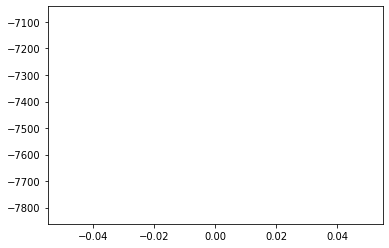

In [3]:
#Проверь на зенитке, на cartpole и на mountain car
EPISODES=1400

print('_____',pd.Timestamp.now())
#здесь весь код от инициализации модели до выдачи scores.
# In case of CartPole-v1, maximum length of episode is 500

env = jet_table_simple.jet_table_simple_env()
#env = gym.make('Seaquest-ramNoFrameskip-v0')
#env=CartPoleEnv9()
# get size of state and action from environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

#agent = sarsa.SarsaAgent(state_size, action_size)
agent = graph_ai.GraphAI(state_size, action_size)
agent.rl.train_start=340
#agent.train_start=7000
#agent.epsilon_decay=0.9999
agent.render=True

scores, episodes = [], []
reward_lst = []
s_list=[]
a_list=[]
agent.epsilon = 1

for e in range(EPISODES):
    done = False
    score = 0
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    

    while not done:
        if (e in range(0,18)) or (e in range(20,22)) or (e in range(30,32)) or (e in range(40,42)) or (e in range(50,52)) or (e in range(100,103)) or (e in range(200,202)) or (e in range(300,306)) or (e in range(400,406)) or (e in range(500,506)) or (e in range(600,604)):
            if agent.render:
                env.render()

        # get action for the current state and go one step in environment)
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        # if an action make the episode end, then gives penalty of -100


        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, done)
        #if next_state[0,11]!=reward:
        #    print('state[13]!=reward',state[0,11],reward)
        #
        s_list.append(state)
        a_list.append(action)
        reward_lst.append(reward)
        #

        # every time step do the training
        agent.train_model()
        score += reward
        state = next_state

        if done:
            # every episode update the target model to be same with model
            agent.update_target_model()

            # every episode, plot the play time
            scores.append(score)
            episodes.append(e)
            pylab.plot(episodes, scores, 'b')
            #pylab.savefig("./save_graph/aa_gun_dqn.png")
            try:
                print("episode:", e, "  score:", score,np.mean(scores), "  memory length:",
                      len(agent.rl.s), "  epsilon:", agent.epsilon)
            except Exception:
                print("episode:", e, "  score:", score,np.mean(scores), "  memory length:",
                      len(agent.rl.s), "  epsilon:", agent.epsilon)


SSR model: rmse/mean:2.113467561088949
SSAR model: rmse/mean:1.3139849111016793


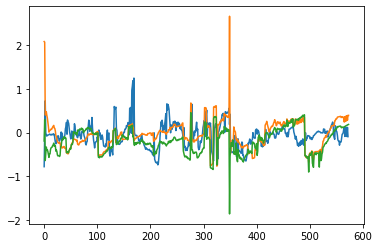

DistanceMeasure rmse 71.99220385226363 rmse/mean =  0.7465630270264655 rmse/std =  1.2671022503890699 shape 825


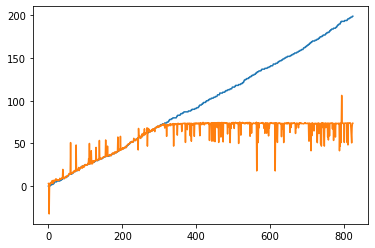

In [8]:
agent.debug_info(2000,1000)

In [ ]:
scores

In [ ]:
figure(num=None, figsize=(13, 13), dpi=80, facecolor='w', edgecolor='k')
nx.draw_spectral(agent.graph)

In [ ]:
figure(num=None, figsize=(13, 13), dpi=80, facecolor='w', edgecolor='k')
nx.draw_kamada_kawai(agent.graph)

In [ ]:
lst = list(agent.graph.edges.values())

In [ ]:
lst